In [1]:
import numpy as np
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "src"))
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from ffnn import FFNN
import time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report, log_loss, roc_auc_score, cohen_kappa_score, precision_recall_fscore_support

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [3]:
def validate_model(model, y_val_encoded, y_val_pred, y_val_pred_proba, label_encoder):
  # Precision, Recall, F1-Score (Weighted and Macro)
  precision, recall, f1, _ = precision_recall_fscore_support(
      y_val_encoded, y_val_pred, average='weighted')
  macro_f1 = f1_score(y_val_encoded, y_val_pred, average='macro')
  print(f"Weighted F1-Score: {f1:.4f}")
  print(f"Macro F1-Score: {macro_f1:.4f}")

  # Cohen's Kappa
  kappa = cohen_kappa_score(y_val_encoded, y_val_pred)
  print(f"Cohen's Kappa: {kappa:.4f}")

  # ROC-AUC (One-vs-Rest for Multi-Class)
  try:
      roc_auc = roc_auc_score(y_val_encoded, y_val_pred_proba, multi_class='ovr', average='weighted')
      print(f"ROC-AUC (Weighted): {roc_auc:.4f}")
  except ValueError:
      print("ROC-AUC could not be computed for this dataset.")

  # Log Loss
  logloss = log_loss(y_val_encoded, y_val_pred_proba)
  print(f"\nValidation Log Loss: {logloss:.4f}")


  # Classfication Report
  print("\nClassification Report:")
  print(classification_report(label_encoder.inverse_transform(y_val_encoded),
                              label_encoder.inverse_transform(y_val_pred),
                              target_names=[str(cls) for cls in label_encoder.classes_] ))

  # Confusion Matrix
  print()
  conf_matrix_id3 = confusion_matrix(label_encoder.inverse_transform(y_val_encoded),
                                    label_encoder.inverse_transform(y_val_pred),
                                    labels=label_encoder.classes_)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_id3, annot=True, fmt='d', cmap='Blues',
              xticklabels=[str(cls) for cls in label_encoder.classes_], 
              yticklabels=[str(cls) for cls in label_encoder.classes_])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

In [4]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

# one-hot encode labels
encoder = OneHotEncoder(sparse=False, categories='auto')
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Untuk konversi balik ke label kelas
label_encoder = LabelEncoder()
label_encoder.fit(np.arange(10))
y_val_encoded = np.argmax(y_val, axis=1)

## Library Sklearn MLP

In [5]:
mlp = MLPClassifier(
    hidden_layer_sizes=(150, 75), 
    activation='relu',            
    solver='sgd',                  
    learning_rate_init=0.001,     
    max_iter=20,                   
    batch_size=64,                 
    random_state=42,          
    verbose=True                   
)

In [6]:
y_train_labels = np.argmax(y_train, axis=1)
mlp.fit(X_train, y_train_labels)
y_val_pred_proba_sklearn = mlp.predict_proba(X_val)
y_val_pred_sklearn = mlp.predict(X_val)

Iteration 1, loss = 2.00135927
Iteration 2, loss = 1.33436734
Iteration 3, loss = 0.65057766
Iteration 4, loss = 0.30626564
Iteration 5, loss = 0.22840551
Iteration 6, loss = 0.18752994
Iteration 7, loss = 0.16398149
Iteration 8, loss = 0.14668459
Iteration 9, loss = 0.13593892
Iteration 10, loss = 0.12728548
Iteration 11, loss = 0.11895813
Iteration 12, loss = 0.10762184
Iteration 13, loss = 0.10351812
Iteration 14, loss = 0.09742458
Iteration 15, loss = 0.09282302
Iteration 16, loss = 0.09009242
Iteration 17, loss = 0.08456122
Iteration 18, loss = 0.07773523
Iteration 19, loss = 0.07822835
Iteration 20, loss = 0.07300438


c:\Users\anton\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Weighted F1-Score: 0.9596
Macro F1-Score: 0.9592
Cohen's Kappa: 0.9551
ROC-AUC (Weighted): 0.9976

Validation Log Loss: 0.1754

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1402
           1       0.99      0.98      0.98      1556
           2       0.96      0.96      0.96      1368
           3       0.95      0.95      0.95      1339
           4       0.95      0.96      0.95      1395
           5       0.93      0.97      0.95      1261
           6       0.97      0.97      0.97      1418
           7       0.97      0.94      0.96      1463
           8       0.95      0.95      0.95      1362
           9       0.93      0.94      0.94      1436

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000




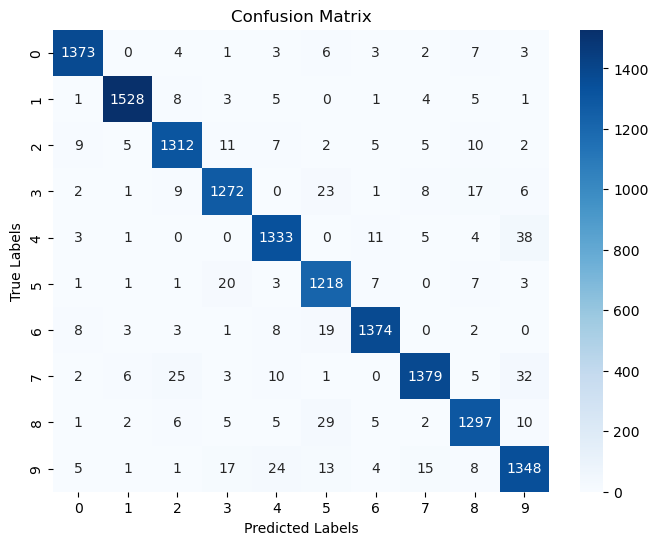

In [7]:
validate_model(mlp, y_val_encoded, y_val_pred_sklearn, y_val_pred_proba_sklearn, label_encoder)

## FFNN From Scratch

In [8]:
layer_sizes = [784, 150, 75, 10] 
activation_funcs = ["relu", "relu", "softmax"] 
model = FFNN(layer_sizes, activation_funcs=activation_funcs, weight_init="xavier", type="uniform", loss_function="cce", seed=42)

# model training
history = model.train(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    batch_size=64,
    learning_rate=0.001,
    epochs=20,
    verbose=1
)

Epoch 1/20 - loss: 1.3256 - val_loss: 0.5818
Epoch 2/20 - loss: 0.4532 - val_loss: 0.4334
Epoch 3/20 - loss: 0.3446 - val_loss: 0.3900
Epoch 4/20 - loss: 0.2882 - val_loss: 0.3495
Epoch 5/20 - loss: 0.2490 - val_loss: 0.3277
Epoch 6/20 - loss: 0.2229 - val_loss: 0.3097
Epoch 7/20 - loss: 0.2022 - val_loss: 0.2998
Epoch 8/20 - loss: 0.1844 - val_loss: 0.2854
Epoch 9/20 - loss: 0.1711 - val_loss: 0.2776
Epoch 10/20 - loss: 0.1591 - val_loss: 0.2710
Epoch 11/20 - loss: 0.1486 - val_loss: 0.2674
Epoch 12/20 - loss: 0.1401 - val_loss: 0.2641
Epoch 13/20 - loss: 0.1324 - val_loss: 0.2543
Epoch 14/20 - loss: 0.1245 - val_loss: 0.2578
Epoch 15/20 - loss: 0.1189 - val_loss: 0.2455
Epoch 16/20 - loss: 0.1132 - val_loss: 0.2461
Epoch 17/20 - loss: 0.1080 - val_loss: 0.2475
Epoch 18/20 - loss: 0.1032 - val_loss: 0.2455
Epoch 19/20 - loss: 0.0995 - val_loss: 0.2452
Epoch 20/20 - loss: 0.0950 - val_loss: 0.2436


In [9]:
model.visualize_weight_distribution()
model.visualize_gradient_weight_distribution()
model.visualize_loss_curve()

In [10]:
predictions = model.predict(X_val)

# convert one-hot predictions back to labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_val, axis=1)

In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(np.arange(10))

y_val_encoded = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(predictions, axis=1) 
y_val_pred_proba = predictions

Weighted F1-Score: 0.9456
Macro F1-Score: 0.9450
Cohen's Kappa: 0.9395
ROC-AUC (Weighted): 0.9965

Validation Log Loss: 0.2436

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1402
           1       0.98      0.98      0.98      1556
           2       0.92      0.95      0.94      1368
           3       0.92      0.93      0.93      1339
           4       0.96      0.93      0.95      1395
           5       0.94      0.93      0.93      1261
           6       0.97      0.96      0.96      1418
           7       0.96      0.94      0.95      1463
           8       0.93      0.93      0.93      1362
           9       0.91      0.92      0.92      1436

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000




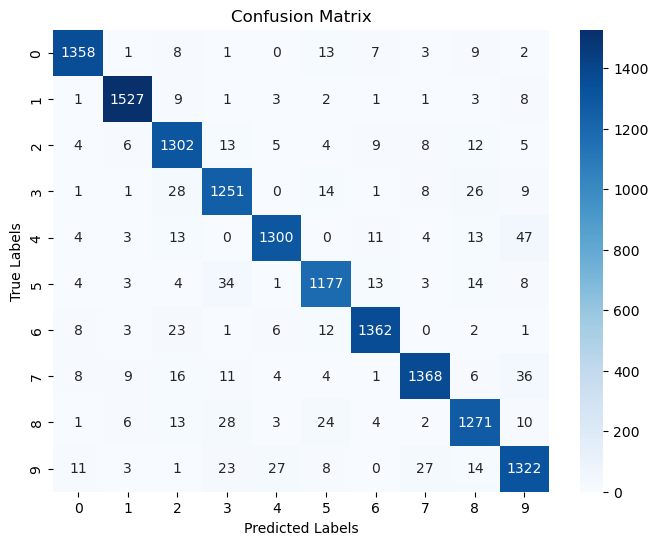

In [12]:
validate_model(model, y_val_encoded, y_val_pred, y_val_pred_proba, label_encoder)
